In [ ]:
import os
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import albumentations as A

TARGET_COUNT = 200
DATASET_DIR = r"C:\Users\matik\Documents\Data Sets\Faulty_solar_panel"
AUGMENTED_DIR = r"C:\Users\matik\Documents\Data Sets\Augmented_Faulty_solar_panel"

# Tworzymy nowy folder, jeśli nie istnieje
os.makedirs(AUGMENTED_DIR, exist_ok=True)

# Definicja augmentacji
augment = A.Compose([
    A.RandomResizedCrop(size=(1024, 1024), scale=(0.6, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=45, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.7),
    A.ColorJitter(p=0.6),
    A.GaussNoise(p=0.4),
    A.GaussianBlur(p=0.3),
])

def load_image(path):
    """Ładuje obraz z podanej ścieżki"""
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def save_image(path, image):
    """Zapisuje obraz w podanej ścieżce"""
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

def copy_original_images(src_dir, dest_dir):
    """Kopiuje oryginalne obrazy do folderu docelowego, zachowując strukturę folderów"""
    for cls in os.listdir(src_dir):
        class_dir = os.path.join(src_dir, cls)
        if not os.path.isdir(class_dir):
            continue
        
        # Tworzymy folder klasy w nowym folderze, jeśli nie istnieje
        new_class_dir = os.path.join(dest_dir, cls)
        os.makedirs(new_class_dir, exist_ok=True)

        # Kopiowanie obrazów
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            new_img_path = os.path.join(new_class_dir, img_name)
            shutil.copy(img_path, new_img_path)

def generate_augmented_images(class_dir, n_to_generate):
    """Generuje brakujące obrazy z augmentacji"""
    images = os.listdir(class_dir)
    augmented_images = []

    for i in tqdm(range(n_to_generate)):
        img_name = np.random.choice(images)
        img_path = os.path.join(class_dir, img_name)

        img = load_image(img_path)
        augmented = augment(image=img)["image"]

        # Nowa nazwa obrazu
        new_name = f"aug_{i}_{img_name}"
        augmented_images.append((new_name, augmented))
    
    return augmented_images

# Kopiujemy oryginalne obrazy do folderu augmented
copy_original_images(DATASET_DIR, AUGMENTED_DIR)

# Przechodzimy przez każdą klasę
for cls in os.listdir(DATASET_DIR):
    class_dir = os.path.join(DATASET_DIR, cls)
    if not os.path.isdir(class_dir):
        continue

    new_class_dir = os.path.join(AUGMENTED_DIR, cls)
    original_images = os.listdir(class_dir)
    n_existing = len(original_images)

    print(f"\nClass: {cls} | Existing images: {n_existing}")

    # Jeśli liczba istniejących zdjęć jest mniejsza niż TARGET_COUNT, generujemy brakujące
    if n_existing < TARGET_COUNT:
        n_to_generate = TARGET_COUNT - n_existing
        augmented_images = generate_augmented_images(class_dir, n_to_generate)

        # Zapisujemy wygenerowane obrazy
        for new_name, augmented in augmented_images:
            save_image(os.path.join(new_class_dir, new_name), augmented)

    else:
        print(f"Class {cls} already has {n_existing} images, no augmentation needed.")


In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())  
print("CUDA version:", torch.version.cuda)          
print("Device:", torch.device("cuda"))             
print("GPU name:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Importy wymagane do działania modelu
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
from PIL import Image

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Ścieżka do folderu z danymi
base_dir = r"C:\Users\matik\Documents\Data Sets\Augmented_Faulty_solar_panel"

# Definicja transformacji dla obrazów
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Dopasowanie rozmiaru
    transforms.ToTensor(),  # Konwersja na tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizacja (jak w ImageNet)
])

# Ładowanie danych z ImageFolder
dataset = datasets.ImageFolder(base_dir, transform=transform)

# Użycie sklearn do stratyfikowanego podziału
# Tworzymy listę etykiet dla każdego obrazu
labels = [sample[1] for sample in dataset.samples]

# Podział danych na zbiór treningowy, walidacyjny i testowy (80%, 10%, 10%) przy zachowaniu proporcji klas
train_indices, temp_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=labels)
valid_indices, test_indices = train_test_split(temp_indices, test_size=0.5, stratify=[labels[i] for i in temp_indices])

# Tworzymy nowe zbiory przy użyciu tych indeksów
train_dataset = torch.utils.data.Subset(dataset, train_indices)
valid_dataset = torch.utils.data.Subset(dataset, valid_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# DataLoader dla treningu, walidacji i testów
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [35]:
# Wczytanie wstępnie wytrenowanego modelu ResNet50
model = models.resnet50(pretrained=True)

# Zamrażamy wszystkie warstwy bazowe, by nie trenować ich ponownie
for param in model.parameters():
    param.requires_grad = False

# Zmiana ostatniej warstwy (fully connected) na dostosowaną do naszej liczby klas
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(dataset.classes))  # Liczba klas
)

# Przenosimy model na GPU (jeśli dostępne)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


c:\Users\matik\AppData\Local\Programs\Python\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matik\AppData\Local\Programs\Python\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# Optymalizator i funkcja straty
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Możemy także ustawić scheduler dla dynamicznej zmiany współczynnika uczenia (opcjonalnie)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [40]:
# Funkcja do trenowania modelu
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Przełączamy model w tryb treningowy
        running_loss = 0.0
        correct = 0
        total = 0

        # Trening
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Walidacja
        model.eval()  # Przełączamy model w tryb ewaluacji
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss = running_loss / len(valid_loader)
        valid_accuracy = 100 * correct / total

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

# Trenowanie modelu
model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs=30
)


Epoch 1/30
Train Loss: 0.3925, Train Accuracy: 85.39%
Valid Loss: 0.6217, Valid Accuracy: 81.82%
Epoch 2/30
Train Loss: 0.3338, Train Accuracy: 88.50%
Valid Loss: 0.6206, Valid Accuracy: 80.99%
Epoch 3/30
Train Loss: 0.3467, Train Accuracy: 87.15%
Valid Loss: 0.6372, Valid Accuracy: 80.17%
Epoch 4/30
Train Loss: 0.2994, Train Accuracy: 88.60%
Valid Loss: 0.6365, Valid Accuracy: 79.34%
Epoch 5/30
Train Loss: 0.3385, Train Accuracy: 87.77%
Valid Loss: 0.6761, Valid Accuracy: 79.34%
Epoch 6/30
Train Loss: 0.2922, Train Accuracy: 89.64%
Valid Loss: 0.6247, Valid Accuracy: 81.82%
Epoch 7/30
Train Loss: 0.2471, Train Accuracy: 90.16%
Valid Loss: 0.6395, Valid Accuracy: 80.17%
Epoch 8/30
Train Loss: 0.2820, Train Accuracy: 89.12%
Valid Loss: 0.7517, Valid Accuracy: 78.51%
Epoch 9/30
Train Loss: 0.3585, Train Accuracy: 89.12%
Valid Loss: 0.6920, Valid Accuracy: 79.34%
Epoch 10/30
Train Loss: 0.4063, Train Accuracy: 85.70%
Valid Loss: 0.5890, Valid Accuracy: 81.82%
Epoch 11/30
Train Loss: 0.304

In [41]:
# Ocena modelu na zbiorze testowym
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 88.43%


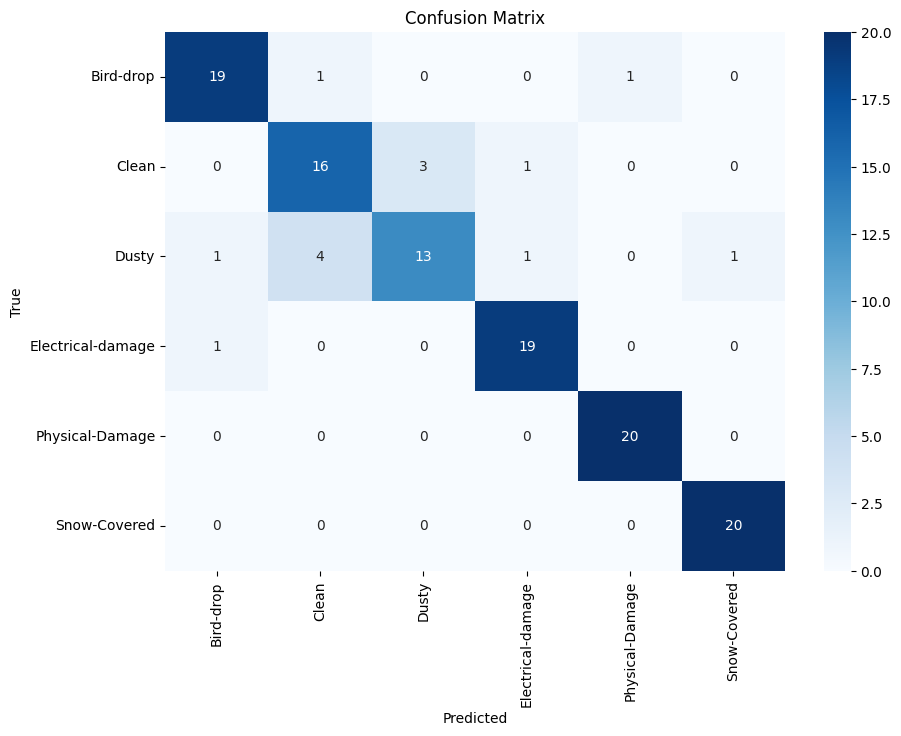

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Funkcja do uzyskania przewidywań modelu na zbiorze testowym
def get_predictions(model, test_loader):
    model.eval()  # Ustawiamy model w tryb ewaluacji
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())  # Zbieramy przewidywania
            all_labels.extend(labels.cpu().numpy())  # Zbieramy prawdziwe etykiety

    return np.array(all_labels), np.array(all_preds)  # Zwracamy etykiety prawdziwe i przewidywane

# Uzyskiwanie przewidywań na zbiorze testowym
true_labels, pred_labels = get_predictions(model, test_loader)

# Generowanie confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Rysowanie macierzy pomyłek jako heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_loader.dataset.dataset.classes, yticklabels=test_loader.dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


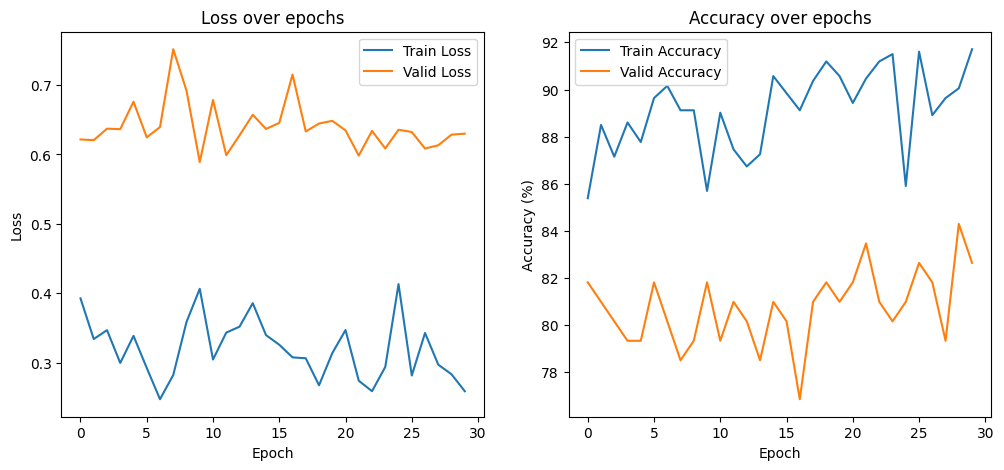

In [43]:
# Wykresy strat i dokładności
plt.figure(figsize=(12, 5))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(valid_accuracies, label="Valid Accuracy")
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.8099348].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.64].
Clippi

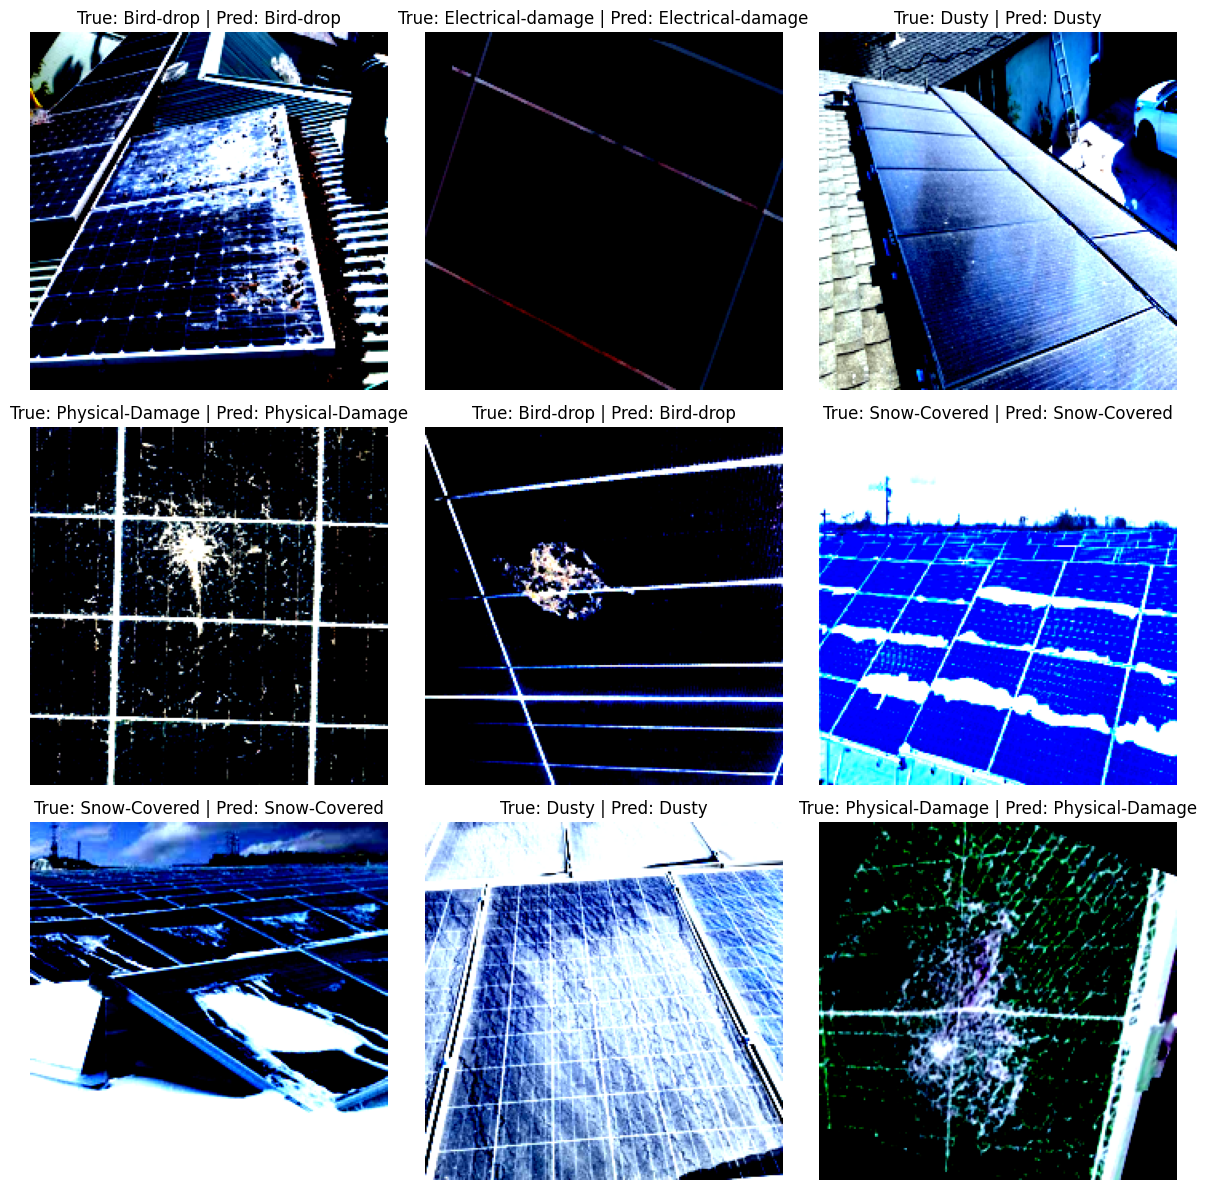

In [44]:
# Funkcja do wyświetlania losowej liczby obrazów z każdej kategorii
def show_random_images(loader, model, num_images=2):
    model.eval()  # Przełączamy model na tryb ewaluacji

    # Uzyskiwanie nazw klas z oryginalnego datasetu
    class_names = loader.dataset.dataset.classes  # Pobieramy nazwy klas z datasetu (ImageFolder)

    # Losowanie określonej liczby obrazów z całego zbioru
    indices = random.sample(range(len(loader.dataset)), num_images)

    # Obliczamy liczbę wierszy potrzebnych do wyświetlenia obrazów w grupach po 3
    rows = (num_images // 3) + (1 if num_images % 3 > 0 else 0)

    fig, axes = plt.subplots(rows, 3, figsize=(12, 4 * rows))

    # Jeśli tylko 1 wiersz, to axes będzie jednowymiarową tablicą
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        image, label = loader.dataset[idx]  # Pobieramy obraz i jego etykietę
        image = image.to(device)

        # Przewidywanie klasy dla obrazu
        output = model(image.unsqueeze(0))  # Dodajemy wymiar wsadowy
        _, pred = torch.max(output, 1)

        # Wyświetlanie obrazu
        ax = axes[i]
        ax.imshow(image.cpu().permute(1, 2, 0))  # Konwersja z (C, H, W) na (H, W, C)
        ax.set_title(f"True: {class_names[label]} | Pred: {class_names[pred]}")
        ax.axis('off')

    # Usuwanie pustych sub-plot, jeśli obrazów jest mniej niż 3 na ostatnim wierszu
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Wyświetlanie 5 losowych obrazów w zbiorze testowym (3 obrazy w pierwszym wierszu, 2 w drugim)
show_random_images(test_loader, model, num_images=9)
